In [1]:
# !set CUDA_VISIBLE_DEVICES=""
# !set CUDA_LAUNCH_BLOCKING=1

In [1]:
import pandas as pd
import sklearn
import os
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
os.environ["KERAS_BACKEND"] = 'torch'
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import keras

In [2]:
np.random.seed(42)#10
torch.manual_seed(42)#42

In [2]:
# torch.backends.cudnn.enabled = False
# torch.cuda.is_available = lambda: False
# torch.device("cpu")

device(type='cpu')

In [3]:
torch.cuda.is_available()

True

In [44]:
df = pd.read_csv('pmi-data.csv')
test_df = df.loc[df['split'] == 'test']
df = df.loc[df['split'] == 'train']

In [4]:
%%html
<h1>1. Datasets and Dataloaders</h1>

In [45]:
train_data, valid_data = sklearn.model_selection.train_test_split(df, test_size=0.25, shuffle=True, random_state=120)

In [46]:
minmax_scaler = sklearn.preprocessing.MinMaxScaler()
# train_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.fit_transform(train_data[['age', 'avg_glucose_level', 'bmi']])
# valid_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.transform(valid_data[['age', 'avg_glucose_level', 'bmi']])

In [48]:
class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data['stroke']
        self.samples = data.drop(columns=['stroke', 'id', 'split'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.samples.iloc[idx].values), torch.tensor(self.labels.iloc[idx])

In [50]:
train_dataloader = DataLoader(StrokeDataset(train_data), batch_size=32, shuffle=True)
valid_dataloader = DataLoader(StrokeDataset(valid_data))

In [9]:
%%html
<h3>I think shuffling is a good idea because if we take a look at the pmi-data.csv we can see that all the cases with stroke=1 come first in the csv so that means if we didnt shuffle, all of them would be chosen for the training and none would be left for the testing</h3>

In [10]:
%%html
<h1>2. Model</h1>

In [368]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.l1 = torch.nn.Linear(in_size, 64)
        self.l2 = torch.nn.Linear(64, 32)
        self.l3 = torch.nn.Linear(32, 16)
        self.l4 = torch.nn.Linear(16, 16)
        # self.l5 = torch.nn.Linear(8, 8)
        # self.l6 = torch.nn.Linear(8, 8)
        # self.l7 = torch.nn.Linear(8, 8)
        # self.l8 = torch.nn.Linear(8, 16)
        # self.l9 = torch.nn.Linear(16, 16)
        # self.l10 = torch.nn.Linear(16, 16)
        # self.l11 = torch.nn.Linear(16, 8)
        self.l12 = torch.nn.Linear(16, out_size)

        self.dropout = torch.nn.Dropout(0.3)

        # torch.nn.init.xavier_uniform_(self.l1.weight)
        # torch.nn.init.xavier_uniform_(self.l2.weight)
        # torch.nn.init.xavier_uniform_(self.l3.weight)
        # torch.nn.init.xavier_uniform_(self.l4.weight)
        # torch.nn.init.xavier_uniform_(self.l5.weight)
        # # torch.nn.init.xavier_uniform_(self.l6.weight)
        # # torch.nn.init.xavier_uniform_(self.l7.weight)
        # # torch.nn.init.xavier_uniform_(self.l8.weight)
        # # torch.nn.init.xavier_uniform_(self.l9.weight)
        # # torch.nn.init.xavier_uniform_(self.l10.weight)
        # # torch.nn.init.xavier_uniform_(self.l11.weight)
        # torch.nn.init.xavier_uniform_(self.l12.weight)
    def forward(self, x):
        x = F.relu(self.l1(x))
        # x = self.dropout(x)
        x = F.relu(self.l2(x))
        # x = self.dropout(x)
        x = F.relu(self.l3(x))
        # x = self.dropout(x)
        x = F.relu(self.l4(x))
        # x = self.dropout(x)
        # x = F.relu(self.l5(x))
        # x = F.relu(self.l6(x))
        # x = F.relu(self.l7(x))
        # x = F.relu(self.l8(x))
        # x = F.relu(self.l9(x))
        # x = F.relu(self.l10(x))
        # x = F.relu(self.l11(x))
        x = self.l12(x)
        return x.squeeze()

def get_y_pred_y_true_valid_loss(model, threshold = 0.5, return_probs = False):
    y_pred = []
    y_true = []
    probs = []
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels[0])
            outputs = model.forward(features)
            
            probs.append(torch.sigmoid(outputs).cpu().numpy())
            
            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > threshold).int())
            
    if return_probs == True:
        return np.array(probs), y_true
        
    return y_pred, y_true, valid_loss

In [369]:
model = Model(10, 1)

In [370]:
# for param in model.parameters():
#     print(param)

In [371]:
%%html
<h1>3. Optimizer and Loss function</h1>

In [372]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [373]:
%%html
<h1>4. Training </h1>

In [374]:
N_EPOCHS = 50

best_acc = 0

hist_train_loss = []
hist_valid_loss = []
hist_accuracy = []

for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0
    valid_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}')
    if accuracy > best_acc:
        torch.save(model.state_dict(), 'best_unbalanced_accuracy')
        best_acc = accuracy

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.29130600448419797, valid_loss=0.21953979631961645
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.2477100495415837, valid_loss=0.19567118520322052
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.23365148790736698, valid_loss=0.20742409301171966
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.21604531692035162, valid_loss=0.17448218474047048
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.21318669845141583, valid_loss=0.17012245240418808
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.20807263766651724, valid_loss=0.16789419319987464
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.20428524894723252, valid_loss=0.1688921777596815
Epoch 7, accuracy: 0.9565217391304348, train_loss=0.20415042796686514, valid_loss=0.16424223751373077
Epoch 8, accuracy: 0.9565217391304348, train_loss=0.20132043268253555, valid_loss=0.1695006299152615
Epoch 9, accuracy: 0.9565217391304348, train_loss=0.19974890456938033, valid_loss=0.1

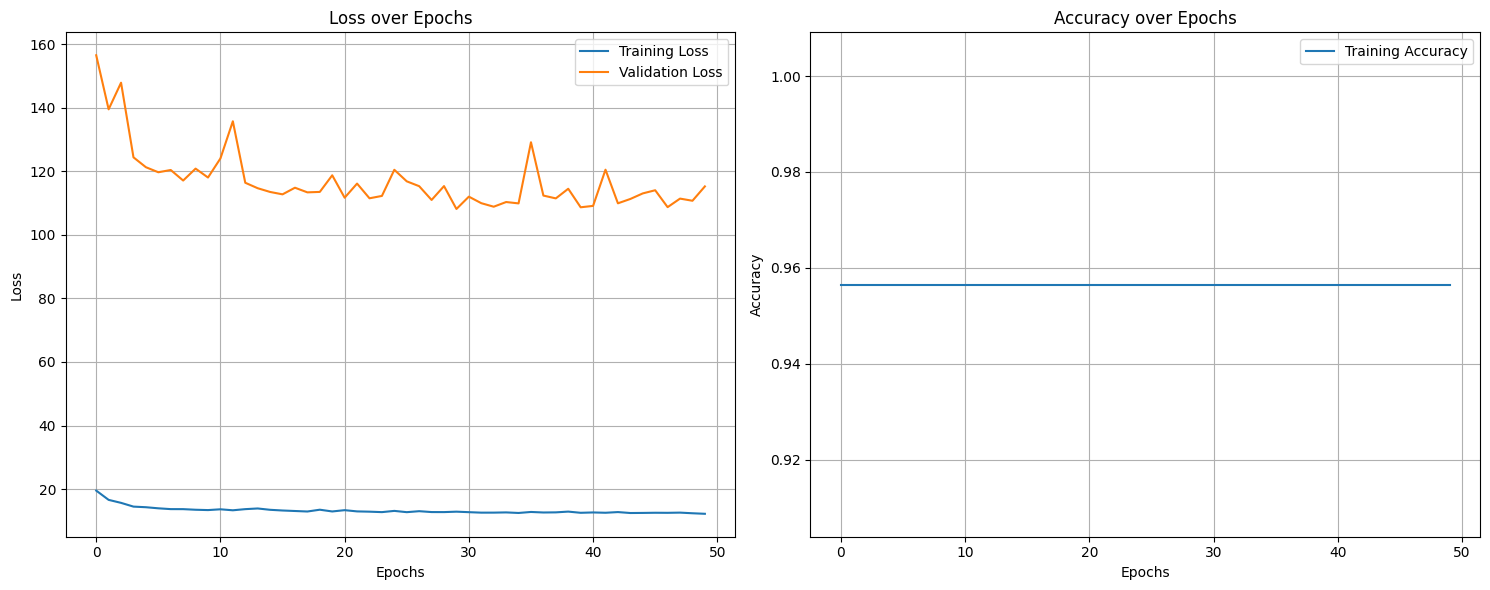

In [375]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [376]:
%%html
<h1>5. Evaluation</h1>

In [377]:
model.load_state_dict(torch.load('best_unbalanced_accuracy'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

Precision: 0.0
Recall: 0.0
F1_score: 0.0


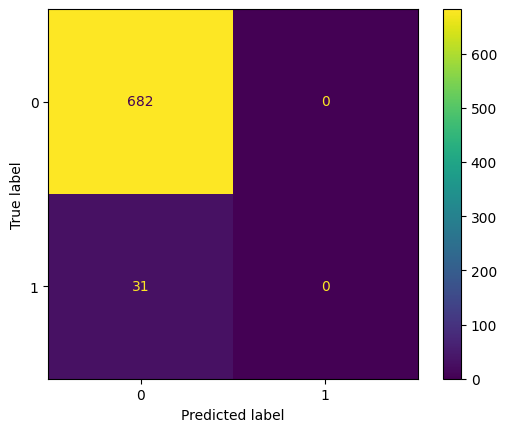

In [378]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred,zero_division=0)
f1_score = sklearn.metrics.f1_score(y_true, y_pred,zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [379]:
%%html
<h1>6. Balance the training data distribution</h1>

In [380]:
model = Model(10, 1)
pos_weight = torch.tensor(train_data['stroke'].loc[train_data.stroke == 0].count() / train_data['stroke'].loc[train_data.stroke == 1].count())
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [381]:
pos_weight

tensor(16.5328, dtype=torch.float64)

In [383]:
N_EPOCHS = 100

best_f1_score = -1

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss / len(train_dataloader))
    hist_valid_loss.append(valid_loss / len(valid_dataloader))
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=1.4552446701633397, valid_loss=1.1861874853243835, f1_score=0.0, recall=0.0, precision=0.0, *
Epoch 1, accuracy: 0.9565217391304348, train_loss=1.3703394549996106, valid_loss=1.1557528540847346, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9565217391304348, train_loss=1.3272824990215586, valid_loss=1.1420250003334516, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9481065918653576, train_loss=1.2996968671457092, valid_loss=1.1331631340201407, f1_score=0.05128205128205128, recall=0.03225806451612903, precision=0.125, *
Epoch 4, accuracy: 0.7180925666199158, train_loss=1.2815507116602427, valid_loss=1.1236298728373744, f1_score=0.1862348178137652, recall=0.7419354838709677, precision=0.10648148148148148, *
Epoch 5, accuracy: 0.5133239831697055, train_loss=1.2637443266697783, valid_loss=1.1123629161803283, f1_score=0.14742014742014742, recall=0.967741935483871, precision=0.0797872340425532, None
Ep

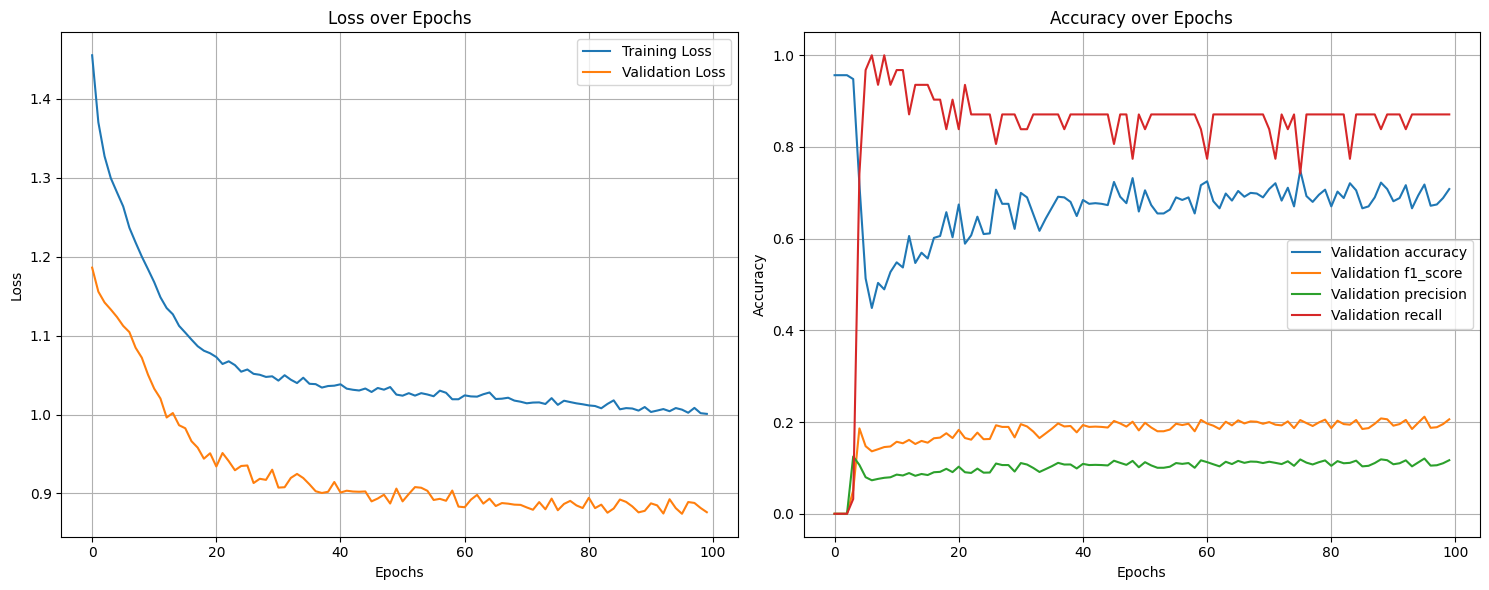

In [384]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Precision: 0.12053571428571429
Recall: 0.8709677419354839
F1_score: 0.21176470588235294


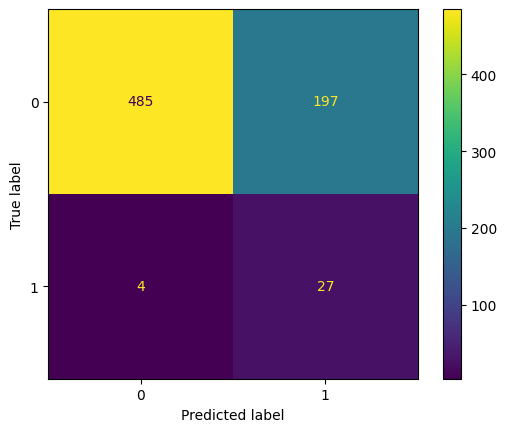

In [448]:
model.load_state_dict(torch.load('best_balanced_f1'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [ ]:
%%html
<h1>7. Focal Loss</h1>

In [386]:
class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # pt = p if target=1, else 1-p
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [395]:
model = Model(10, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = BinaryFocalLoss(alpha=0.7, gamma=2)

In [396]:
N_EPOCHS = 50

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1_focal_loss')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss / len(train_dataloader))
    hist_valid_loss.append(valid_loss / len(valid_dataloader))
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.04016725399267318, valid_loss=0.034117918444580564, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.03805984031242221, valid_loss=0.03239875886887103, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.036430701446622166, valid_loss=0.030991542821183153, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.034034670691992806, valid_loss=0.028423941745468497, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.03255329030885625, valid_loss=0.028966635260874663, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.031895239489959246, valid_loss=0.02694161857597838, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.03114207906287108, valid_loss=0.027260541829357

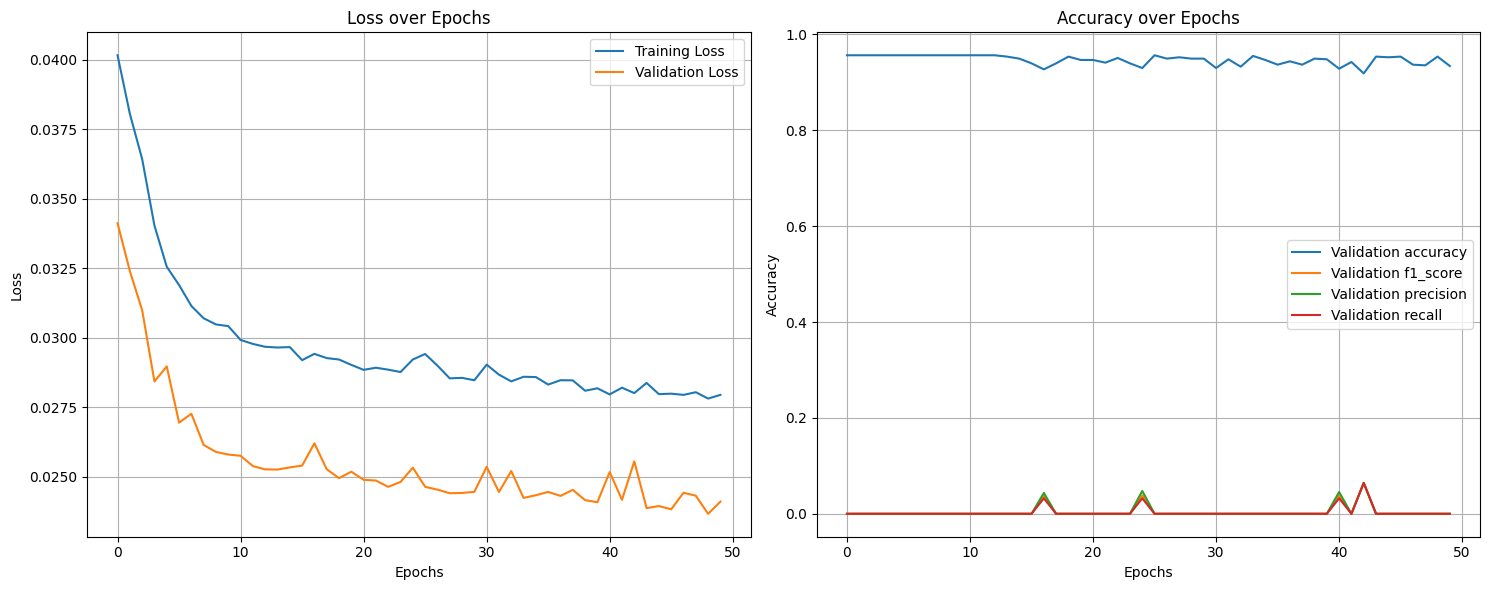

In [397]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Precision: 0.06451612903225806
Recall: 0.06451612903225806
F1_score: 0.06451612903225806


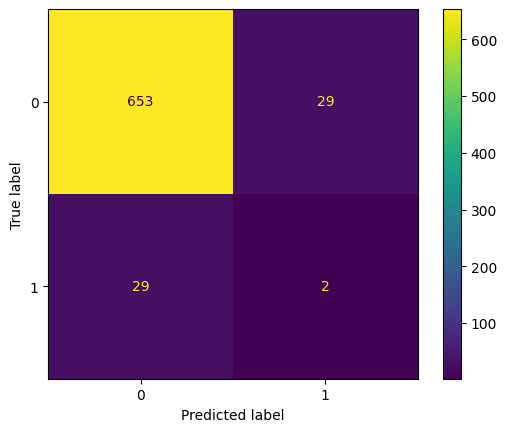

In [447]:
model =  Model(10, 1)
model.load_state_dict(torch.load('best_balanced_f1_focal_loss'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [399]:
%%html
<h1>8. Inspecting model outputs. NOT DONE YET</h1>

In [400]:
model_unbalanced_accuracy = Model(10, 1)
model_unbalanced_accuracy.load_state_dict(torch.load('best_unbalanced_accuracy'))

model_balanced_f1 = Model(10, 1)
model_balanced_f1.load_state_dict(torch.load('best_balanced_f1'))

model_balanced_f1_focal = Model(10, 1)
model_balanced_f1_focal.load_state_dict(torch.load('best_balanced_f1_focal_loss'))

<All keys matched successfully>

In [401]:
def probabilities(model):
    probs = []
    with torch.no_grad():
        for data, label in valid_dataloader:
            if label == 0:
                continue
            logits = model(data)
            probs.append(torch.sigmoid(logits))        
    return np.array(probs)

vals_model_unbalanced_accuracy, _ = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, return_probs=True)
vals_model_balanced_f1, _ = get_y_pred_y_true_valid_loss(model_balanced_f1, return_probs=True)
vals_model_f1_focal, _ = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, return_probs=True)

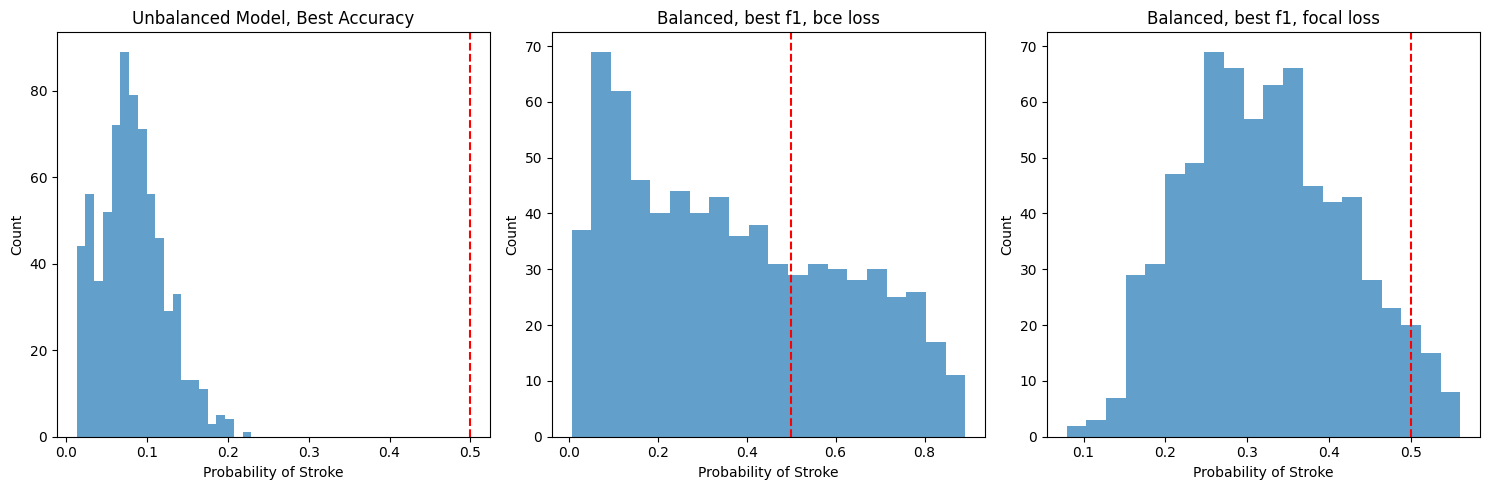

In [402]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(vals_model_unbalanced_accuracy, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Unbalanced Model, Best Accuracy')

plt.subplot(1, 3, 2)
plt.hist(vals_model_balanced_f1, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Balanced, best f1, bce loss')

plt.subplot(1, 3, 3)
plt.hist(vals_model_f1_focal, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Balanced, best f1, focal loss')

plt.tight_layout()
plt.show()

In [403]:
%%html
<h3>The model trained with focal loss 'focuses' more on predicting the probability of stroke = true</h3>

In [404]:
%%html
<h1>9. Beyond default thresholds</h1>

In [405]:
def get_f1_score_models(threshold):
    f1_scores_model_unbalanced_accuracy = None
    f1_scores_model_balanced_f1 = None
    f1_scores_model_balanced_f1_focal = None

    y_pred_model_unbalanced_accuracy = []
    y_pred_model_balanced_f1 = []
    y_pred_model_balanced_f1_focal = []
    y_true = []
    
    y_pred_model_unbalanced_accuracy, y_true_1, _ = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, threshold)
    y_pred_model_balanced_f1, y_true_2, _ = get_y_pred_y_true_valid_loss(model_balanced_f1, threshold)
    y_pred_model_balanced_f1_focal, y_true_3, _ = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, threshold)

    f1_scores_model_unbalanced_accuracy = sklearn.metrics.f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
    f1_scores_model_balanced_f1 = sklearn.metrics.f1_score(y_true_2, y_pred_model_balanced_f1)
    f1_scores_model_balanced_f1_focal = sklearn.metrics.f1_score(y_true_3, y_pred_model_balanced_f1_focal)

    return f1_scores_model_unbalanced_accuracy, f1_scores_model_balanced_f1, f1_scores_model_balanced_f1_focal

In [406]:
history_thresholds = []
maximum = 0
max_threshold = -1
for threshold in np.arange(0.25, 0.76, 0.01):
    history_thresholds.append(get_f1_score_models(threshold))
    prev_max = maximum
    maximum = max(maximum, max(history_thresholds[-1]))
    if prev_max != maximum:
        max_threshold = threshold

In [407]:
print(f'Best f1 validation score is {maximum} using the threshold {max_threshold}')

Best f1 validation score is 0.21890547263681592 using the threshold 0.5800000000000003


In [408]:
%%html
<h1>10. Threshold sensitivity</h1>

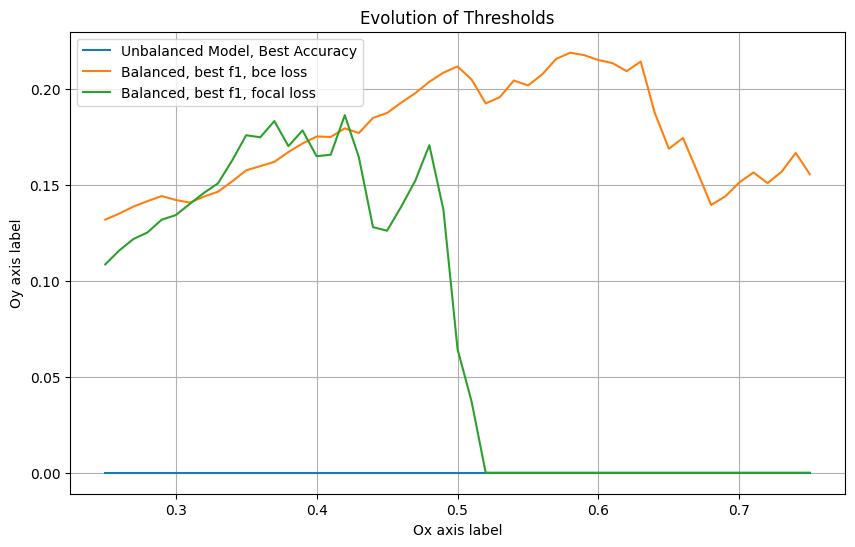

In [409]:
x = np.arange(0.25, 0.76, 0.01)

a = [t[0] for t in history_thresholds]
b = [t[1] for t in history_thresholds]
c = [t[2] for t in history_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(x, a, label='Unbalanced Model, Best Accuracy')
plt.plot(x, b, label='Balanced, best f1, bce loss')
plt.plot(x, c, label='Balanced, best f1, focal loss')

plt.xlabel('Ox axis label')
plt.ylabel('Oy axis label')
plt.title('Evolution of Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [426]:
history_thresholds

[(0.0, 0.13191489361702127, 0.1085814360770578),
 (0.0, 0.13507625272331156, 0.11588785046728972),
 (0.0, 0.13870246085011187, 0.12180746561886051),
 (0.0, 0.1415525114155251, 0.12526096033402923),
 (0.0, 0.14418604651162792, 0.13186813186813187),
 (0.0, 0.14218009478672985, 0.13425925925925927),
 (0.0, 0.1407766990291262, 0.14009661835748793),
 (0.0, 0.14392059553349876, 0.14583333333333334),
 (0.0, 0.14646464646464646, 0.15083798882681565),
 (0.0, 0.1518324607329843, 0.16265060240963855),
 (0.0, 0.15760869565217392, 0.1758957654723127),
 (0.0, 0.15977961432506887, 0.17482517482517482),
 (0.0, 0.16201117318435754, 0.18326693227091634),
 (0.0, 0.16714697406340057, 0.1702127659574468),
 (0.0, 0.17159763313609466, 0.1784037558685446),
 (0.0, 0.17522658610271905, 0.16494845360824742),
 (0.0, 0.175, 0.16574585635359115),
 (0.0, 0.1794871794871795, 0.18633540372670807),
 (0.0, 0.17704918032786884, 0.1643835616438356),
 (0.0, 0.18493150684931506, 0.128),
 (0.0, 0.1875, 0.12612612612612611),


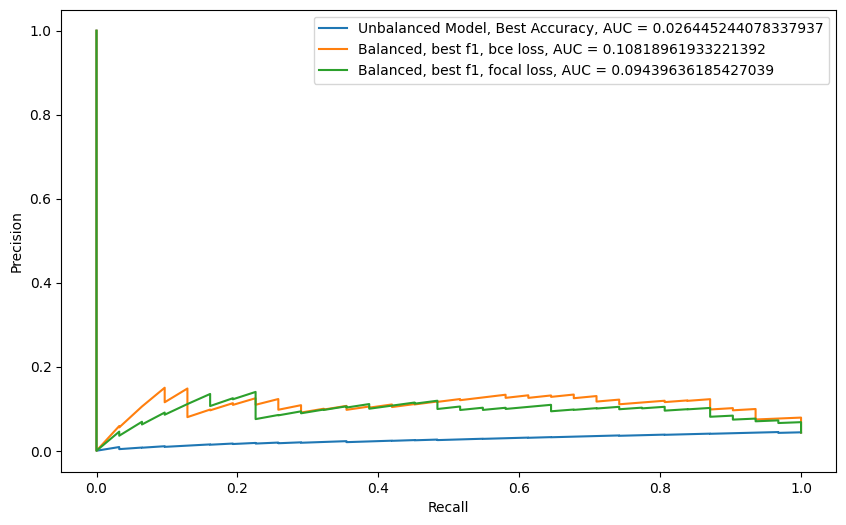

In [410]:
y_pred_model_unbalanced_accuracy, y_true_1 = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, return_probs=True)
y_pred_model_balanced_f1, y_true_2 = get_y_pred_y_true_valid_loss(model_balanced_f1, return_probs=True)
y_pred_model_balanced_f1_focal, y_true_3 = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, return_probs=True)

precision_recall_curve_model_unbalanced_accuracy = sklearn.metrics.precision_recall_curve(y_true_1, y_pred_model_unbalanced_accuracy)
precision_recall_curve_model_balanced_f1 = sklearn.metrics.precision_recall_curve(y_true_2, y_pred_model_balanced_f1)
precision_recall_curve_model_balanced_f1_focal = sklearn.metrics.precision_recall_curve(y_true_3, y_pred_model_balanced_f1_focal)

auc_model_unbalanced_accuracy = sklearn.metrics.auc(precision_recall_curve_model_unbalanced_accuracy[1], precision_recall_curve_model_unbalanced_accuracy[0])
auc_model_balanced_f1 = sklearn.metrics.auc(precision_recall_curve_model_balanced_f1[1], precision_recall_curve_model_balanced_f1[0])
auc_model_balanced_f1_focal = sklearn.metrics.auc(precision_recall_curve_model_balanced_f1_focal[1], precision_recall_curve_model_balanced_f1_focal[0])

plt.figure(figsize=(10, 6))
plt.plot(precision_recall_curve_model_unbalanced_accuracy[1], precision_recall_curve_model_unbalanced_accuracy[0], label =f'Unbalanced Model, Best Accuracy, AUC = {auc_model_unbalanced_accuracy}')
plt.plot(precision_recall_curve_model_balanced_f1[1], precision_recall_curve_model_balanced_f1[0], label=f'Balanced, best f1, bce loss, AUC = {auc_model_balanced_f1}')
plt.plot(precision_recall_curve_model_balanced_f1_focal[1], precision_recall_curve_model_balanced_f1_focal[0], label=f'Balanced, best f1, focal loss, AUC = {auc_model_balanced_f1_focal}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [411]:
%%html
<h1>12. Test performance</h1>

In [412]:
test_dataloader = DataLoader(StrokeDataset(test_df))

In [415]:
def get_y_pred_y_true_from_dataloader(model, dataloader, threshold = 0.5):
    y_pred = []
    y_true = []
    probs = []
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            features, labels = data
            y_true.append(labels[0])
            outputs = model.forward(features)
            
            probs.append(torch.sigmoid(outputs).cpu().numpy())
            
            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > threshold).int())
        
    return y_pred, y_true

In [439]:
y_pred_model_unbalanced_accuracy, y_true_1 = get_y_pred_y_true_from_dataloader(model_unbalanced_accuracy, test_dataloader, 0.5)
y_pred_model_balanced_f1, y_true_2 = get_y_pred_y_true_from_dataloader(model_balanced_f1, test_dataloader, 0.5)
y_pred_model_balanced_f1_focal, y_true_3 = get_y_pred_y_true_from_dataloader(model_balanced_f1_focal, test_dataloader, 0.5)

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
#for unbalanced model
default_f1_model_unbalanced_accuracy = f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
default_precision_model_unbalanced_accuracy = precision_score(y_true_1, y_pred_model_unbalanced_accuracy)
default_recall_model_unbalanced_accuracy = recall_score(y_true_1, y_pred_model_unbalanced_accuracy)
default_accuracy_model_unbalanced_accuracy = accuracy_score(y_true_1, y_pred_model_unbalanced_accuracy)

#for f1-focused balanced model
default_f1_model_balanced_f1 = f1_score(y_true_2, y_pred_model_balanced_f1)
default_precision_model_balanced_f1 = precision_score(y_true_2, y_pred_model_balanced_f1)
default_recall_model_balanced_f1 = recall_score(y_true_2, y_pred_model_balanced_f1)
default_accuracy_model_balanced_f1 = accuracy_score(y_true_2, y_pred_model_balanced_f1)

#for focal-f1-focsued balanced model
default_f1_model_balanced_f1_focal = f1_score(y_true_3, y_pred_model_balanced_f1_focal)
default_precision_model_balanced_f1_focal = precision_score(y_true_3, y_pred_model_balanced_f1_focal)
default_recall_model_balanced_f1_focal = recall_score(y_true_3, y_pred_model_balanced_f1_focal)
default_accuracy_model_balanced_f1_focal = accuracy_score(y_true_3, y_pred_model_balanced_f1_focal)


y_pred_model_unbalanced_accuracy, y_true_1 = get_y_pred_y_true_from_dataloader(model_unbalanced_accuracy, test_dataloader, 0.5)
y_pred_model_balanced_f1, y_true_2 = get_y_pred_y_true_from_dataloader(model_balanced_f1, test_dataloader, 0.58)
y_pred_model_balanced_f1_focal, y_true_3 = get_y_pred_y_true_from_dataloader(model_balanced_f1_focal, test_dataloader, 0.42)

#OPTIMIZED SCORES
#for unbalanced model
optimized_f1_model_unbalanced_accuracy = f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
optimized_precision_model_unbalanced_accuracy = precision_score(y_true_1, y_pred_model_unbalanced_accuracy)
optimized_recall_model_unbalanced_accuracy = recall_score(y_true_1, y_pred_model_unbalanced_accuracy)
optimized_accuracy_model_unbalanced_accuracy = accuracy_score(y_true_1, y_pred_model_unbalanced_accuracy)

#for f1-focused balanced model
optimized_f1_model_balanced_f1 = f1_score(y_true_2, y_pred_model_balanced_f1)
optimized_precision_model_balanced_f1 = precision_score(y_true_2, y_pred_model_balanced_f1)
optimized_recall_model_balanced_f1 = recall_score(y_true_2, y_pred_model_balanced_f1)
optimized_accuracy_model_balanced_f1 = accuracy_score(y_true_2, y_pred_model_balanced_f1)

#for focal-f1-focsued balanced model
optimized_f1_model_balanced_f1_focal = f1_score(y_true_3, y_pred_model_balanced_f1_focal)
optimized_precision_model_balanced_f1_focal = precision_score(y_true_3, y_pred_model_balanced_f1_focal)
optimized_recall_model_balanced_f1_focal = recall_score(y_true_3, y_pred_model_balanced_f1_focal)
optimized_accuracy_model_balanced_f1_focal = accuracy_score(y_true_3, y_pred_model_balanced_f1_focal)

C:\Users\Fabi\anaconda3\envs\tema1_rna\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fabi\anaconda3\envs\tema1_rna\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [449]:
table = [
    {  
        "Model": "Unbalanced Model, Best Accuracy (Default)",
        "Threshold": 0.50,
        "Accuracy": default_accuracy_model_unbalanced_accuracy,
        "Precision": default_precision_model_unbalanced_accuracy,
        "Recall": default_recall_model_unbalanced_accuracy,
        "F1": default_f1_model_unbalanced_accuracy
    },
    {   
        "Model": "Balanced, best f1, bce loss (Optimized)",
        "Threshold": 0.50, 
        "Accuracy": default_accuracy_model_balanced_f1,
        "Precision": default_precision_model_balanced_f1,
        "Recall": default_recall_model_balanced_f1,
        "F1": default_f1_model_balanced_f1
    },
    {   
        "Model": "Balanced, best f1, focal loss (Default)",
        "Threshold": 0.50,
        "Accuracy": default_accuracy_model_balanced_f1_focal,
        "Precision": default_precision_model_balanced_f1_focal,
        "Recall": default_recall_model_balanced_f1_focal,
        "F1": default_f1_model_balanced_f1_focal
    },
    {   
        "Model": "Balanced, best f1, bce loss (Optimized)",
        "Threshold": 0.58,
        "Accuracy": optimized_accuracy_model_balanced_f1,
        "Precision": optimized_precision_model_balanced_f1,
        "Recall": optimized_recall_model_balanced_f1,
        "F1": optimized_f1_model_balanced_f1
    },
    {  
        "Model": "Balanced, best f1, focal loss (Optimized)",
        "Threshold": 0.42,
        "Accuracy": optimized_accuracy_model_balanced_f1_focal,
        "Precision": optimized_precision_model_balanced_f1_focal,
        "Recall": optimized_recall_model_balanced_f1_focal,
        "F1": optimized_f1_model_balanced_f1_focal
    }
]

df = pd.DataFrame(table)
df = df.style.format({
    "Threshold": "{:.2f}",
    "Accuracy": "{:.6f}",
    "Precision": "{:.6f}", 
    "Recall": "{:.6f}",
    "F1": "{:.6f}"
}).hide(axis="index")

df

Model,Threshold,Accuracy,Precision,Recall,F1
"Unbalanced Model, Best Accuracy (Default)",0.50,0.931373,0.000000,0.000000,0.000000
"Balanced, best f1, bce loss (Optimized)",0.50,0.700280,0.145923,0.693878,0.241135
"Balanced, best f1, focal loss (Default)",0.50,0.903361,0.205882,0.142857,0.168675
"Balanced, best f1, bce loss (Optimized)",0.58,0.766106,0.175824,0.653061,0.277056
"Balanced, best f1, focal loss (Optimized)",0.42,0.802521,0.176056,0.510204,0.261780


In [ ]:
plt.plot(x, a, label='Unbalanced Model, Best Accuracy')
plt.plot(x, b, label='Balanced, best f1, bce loss')
plt.plot(x, c, label='Balanced, best f1, focal loss')